In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cv2
import os
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import torchvision.models as models
import glob
import PIL
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg19(pretrained=True).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


# Hyperparameter Assignment

In [12]:
root = "../input/monet2photo/monet2photo/"

batch_size = 8
image_size = 224
nc = 3
n_epochs = 30
lr = 0.0002

# Dataset

In [3]:
def to_rgb(image):
    rgb_image = PIL.Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

class ImageDataset(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.style = sorted(glob.glob(os.path.join(root, "trainA/" + "*.*")))
        self.content = sorted(glob.glob(os.path.join(root, "trainB/" + "*.*")))
        
    def __getitem__(self, index):
        img_style = PIL.Image.open(self.style[index % len(self.style)])
        img_content = PIL.Image.open(self.content[index % len(self.content)])
        img_style, img_content = to_rgb(img_style), to_rgb(img_content)
        img_style, img_content = self.transform(img_style), self.transform(img_content)
        
        return {"style": img_style, "content": img_content}
    
    def __len__(self):
        return max(len(self.style), len(self.content))

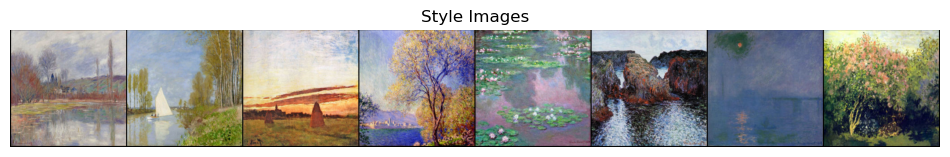

In [4]:
dataset = ImageDataset(root=root, 
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sample = next(iter(loader))['style']
plt.figure(figsize=(12,8), dpi=100)
plt.axis('off')
plt.title("Style Images")
plt.imshow(np.transpose(vutils.make_grid(sample[:batch_size], padding=2, normalize=True), (1,2,0)))

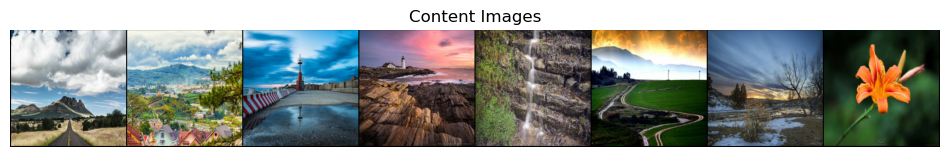

In [5]:
sample = next(iter(loader))['content']
plt.figure(figsize=(12,8), dpi=100)
plt.axis('off')
plt.title("Content Images")
plt.imshow(np.transpose(vutils.make_grid(sample[:batch_size], padding=2, normalize=True), (1,2,0)))

# Helper Functions

In [6]:
def compute_stat(x, eps=1e-8):
    assert len(x.size()) == 4, "Invalid Tensor Shape: {}".format(x.size())
    N, C, H, W = x.size()
    x = x.view(N, C, -1)
    mean = torch.mean(x, dim=2).view(N, C, 1, 1)
    std = torch.std(x, dim=2).view(N, C, 1, 1) + eps
    return mean, std

def AdaIN(style, content):
    assert style.size()[:2] == content.size()[:2], "Dimension Mismatch between style and content, {} vs {}".format(style.size(), content.size())
    size = style.size()
    mean_s, std_s = compute_stat(style)
    mean_c, std_c = compute_stat(content)
    scaled_c = (content - mean_c.expand(size)) / std_c.expand(size)
    return std_s.expand(size) * scaled_c + mean_s.expand(size)

def build_encoder(base_model=vgg):
    base = copy.deepcopy(base_model)
    i = 0
    model = nn.Sequential()
    
    for layer in base.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_{}".format(i)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i)
        else:
            raise RuntimeError("Unrecognized Layer: {}".format(layer.__class__.__name__))
#         if name[:4] == 'conv' and name[5] != "1":
#             model.add_module("pad_{}".format(i), nn.ReflectionPad2d((1,1,1,1)))
        model.add_module(name, layer)
        if name == "relu_9":
            break
            
    return model

# Build Network

In [7]:
encoder = build_encoder(base_model=vgg)
encoder

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_8): ReLU()
  (pool_8): MaxPool2d(kernel

In [8]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)))

decoder

Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): ReflectionPad2d((1, 1, 1, 1))
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): ReflectionPad2d((1, 1, 1, 1))
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): ReflectionPad2d((1, 1, 1, 1))
  (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): Upsample(scale_factor=2.0, mode=nearest)
  (17): ReflectionPad2d((1, 1, 1, 1))
  (18): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (19): ReLU()
  (20): ReflectionPad2d((1, 1, 1, 1))
  (21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (22): ReLU()
  (23): Upsample(scale_factor=2.0, mode=nearest)
  (24): ReflectionPad2d((1, 1, 1, 1))
  (25): Conv2d(64, 64, 

In [9]:
class Net(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:2]) # relu_1_1
        self.enc_2 = nn.Sequential(*enc_layers[2:7]) # relu_2_1
        self.enc_3 = nn.Sequential(*enc_layers[7:12]) # relu_3_1
        self.enc_4 = nn.Sequential(*enc_layers[12:21]) # relu_4_1 (final)

        for param in self.encoder.parameters(): # Freeze VGG encoder
            param.requires_grad = False

        for name in ['enc_{}'.format(i) for i in range(1,5)]: # Freeze separate encoder layers
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    def encode(self, input):
        return self.encoder(input)

    def encode_step(self, input):
        out = [input]
        for i in range(4):
            layer = getattr(self, 'enc_{}'.format(i+1))
            out.append(layer(out[-1]))
        return out[1:] # outputs enc_1, enc_2, enc_3, enc_4 output in a list / for style_loss calc

    def content_loss(self, input_, target):
        assert (input_.size()==target.size()), "Input and target size mismatch"
        target.requires_grad = False
        assert (target.requires_grad == False), "Warning: freeze target gradients"
        loss = nn.MSELoss()
        return loss(input_, target)

    def style_loss(self, input_, target):
        assert (input_.size()==target.size()), "Input and target size mismatch"
        assert (target.requires_grad == False), "Warning: freeze target gradients"
        input_mean, input_std = compute_stat(input_)
        target_mean, target_std = compute_stat(target)
        loss = nn.MSELoss()
        return loss(input_mean, target_mean) + loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0, output_image=False):
        assert 0 <= alpha <= 1, "Invalid interpolation factor"
        style_features = self.encode_step(style)
        content_feature = self.encode(content)

        t = AdaIN(content_feature, style_features[-1])
        t = alpha * t + (1-alpha) * content_feature
        
#         return t
        
        g_t = self.decoder(t)

        if output_image: # View generated image
            return g_t

        g_t_features = self.encode_step(g_t) # Encode once again to compute loss
        
        loss_c = self.content_loss(g_t_features[-1], t)
#         a, b = g_t_features[-1].cpu().detach().numpy(), t.cpu().detach().numpy()
#         print(np.sum(np.isnan(a)))
#         print(np.sum(np.isnan(b)))
        loss_s = self.style_loss(g_t_features[0], style_features[0])
        for i in range(1, 4):
            loss_s += self.style_loss(g_t_features[i], style_features[i])
#             print(g_t_features[i].shape, style_features[i].shape)
        return loss_c, loss_s

In [10]:
model = Net(encoder, decoder)
model.to(device)
model

Net(
  (encoder): Sequential(
    (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1): ReLU()
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2): ReLU()
    (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_3): ReLU()
    (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_4): ReLU()
    (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_5): ReLU()
    (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_6): ReLU()
    (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_7): ReLU()
    (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [11]:
optimizer = optim.Adam(model.decoder.parameters(), lr=lr, betas=(0.5, 0.999))
Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.FloatTensor

# Train

In [13]:
import time
from collections import defaultdict

output = defaultdict(list)

for epoch in range(n_epochs):
    t0 = time.time()
    s, c = 0, 0
    for i, batch in enumerate(loader):
        style = batch['style']
        content = batch['content']
        if torch.cuda.is_available():
            style, content = style.cuda(), content.cuda()
        
        optimizer.zero_grad()
        loss_c, loss_s = model(content, style)
        loss = 0.5 * (loss_c + loss_s)
        loss.backward()
        optimizer.step()
        
        s += loss_s.item()
        c += loss_c.item()
        
    t1 = time.time()
    output['epoch'].append(epoch+1)
    output['Loss_C'].append(c)
    output['Loss_S'].append(s)
    
    print("Epoch: {}".format(epoch+1))
    print("Time Taken: {:.1f}m".format((t1-t0)/60))
    print("Content Loss: {:.4f}".format(c))
    print("Style Loss: {:.4f}".format(s))
    print('-'*50)

Epoch: 1
Time Taken: 3.5m
Content Loss: 3501.2291
Style Loss: 1048.0546
--------------------------------------------------
Epoch: 2
Time Taken: 3.1m
Content Loss: 2555.5709
Style Loss: 537.5382
--------------------------------------------------
Epoch: 3
Time Taken: 3.1m
Content Loss: 2288.5219
Style Loss: 445.9129
--------------------------------------------------
Epoch: 4
Time Taken: 3.1m
Content Loss: 2153.2088
Style Loss: 399.0170
--------------------------------------------------
Epoch: 5
Time Taken: 3.1m
Content Loss: 2060.7386
Style Loss: 368.3617
--------------------------------------------------
Epoch: 6
Time Taken: 3.1m
Content Loss: 1995.5356
Style Loss: 346.7803
--------------------------------------------------
Epoch: 7
Time Taken: 3.1m
Content Loss: 1943.1679
Style Loss: 333.5381
--------------------------------------------------
Epoch: 8
Time Taken: 3.1m
Content Loss: 1900.6427
Style Loss: 318.5726
--------------------------------------------------
Epoch: 9
Time Taken: 3.

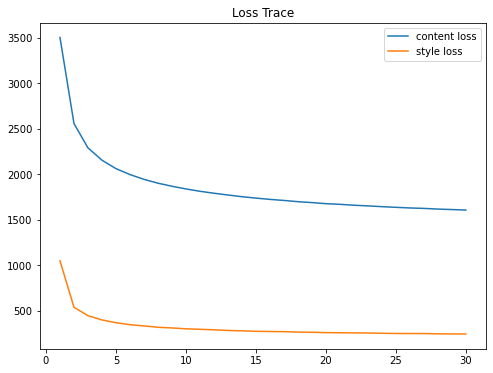

In [14]:
plt.figure(figsize=(8,6))
plt.plot(output['epoch'], output['Loss_C'], label="content loss")
plt.plot(output['epoch'], output['Loss_S'], label="style loss")
plt.title("Loss Trace")
plt.legend()
plt.show()

# Check Output

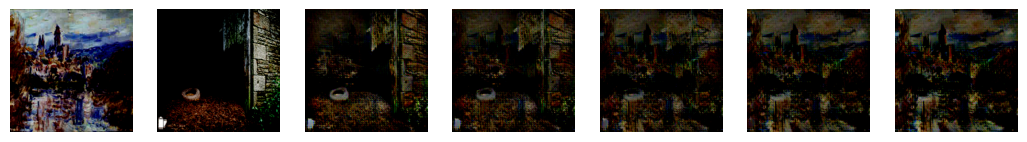

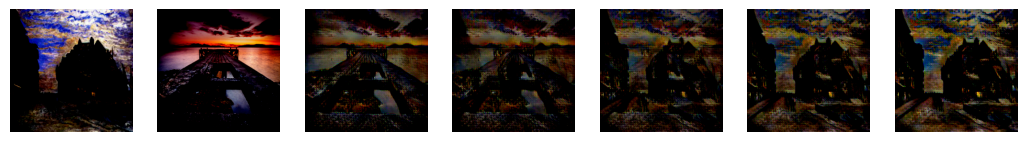

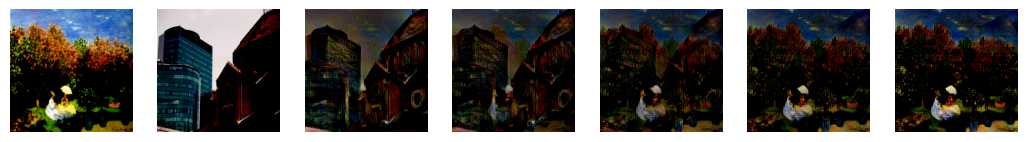

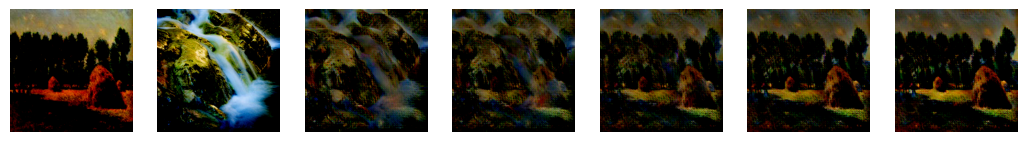

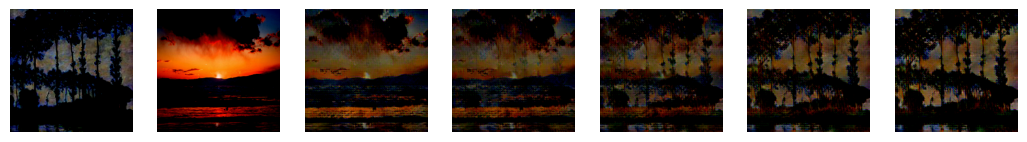

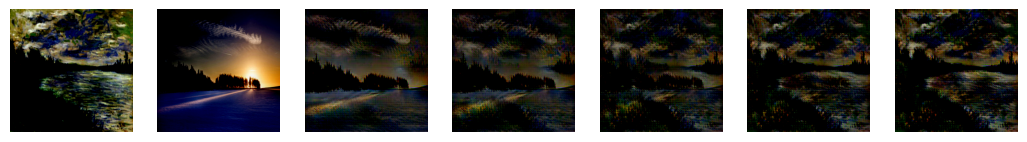

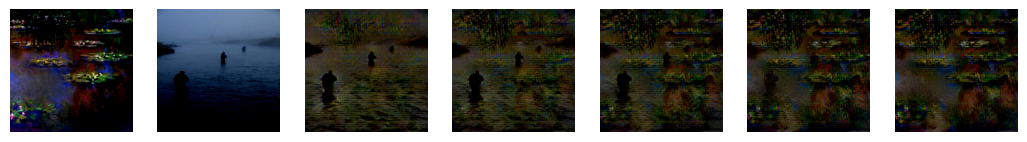

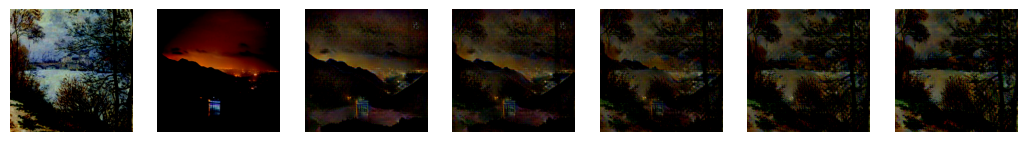

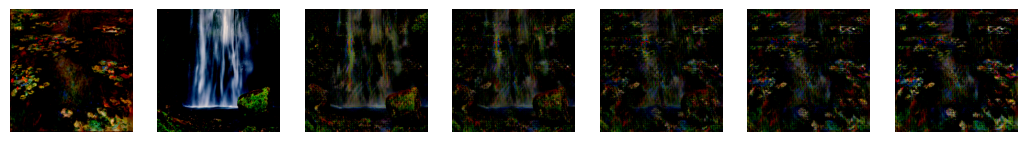

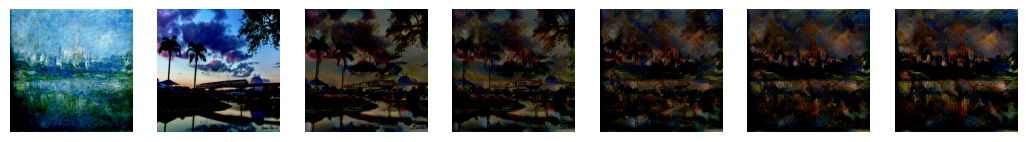

In [23]:
alphas = np.arange(start=0.2, stop=1.2, step=0.2)

for i in range(10):
    j = np.random.randint(0, 8)
    s = next(iter(loader))['style'][j].unsqueeze(0).cuda()
    c = next(iter(loader))['content'][j].unsqueeze(0).cuda()
    outputs = [model(c, s, output_image=True, alpha=a) for a in alphas]
    
    s_img = s.squeeze(0).detach().cpu().permute(1,2,0).numpy()
    c_img = c.squeeze(0).detach().cpu().permute(1,2,0).numpy()
    imgs = [s_img, c_img] + [output.squeeze(0).detach().cpu().permute(1,2,0).numpy() for output in outputs]
    
    fig, ax = plt.subplots(1, 7, figsize=(13,10), dpi=100)
    for k in range(7):
        ax[k].imshow(imgs[k])
        ax[k].axis("off")